<a href="https://colab.research.google.com/github/allifa/tomato-leaf-disease-Iot-ml-/blob/main/Tomato_Leaves_Desease_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4684 files belonging to 5 classes.
Using 3748 files for training.
Found 4684 files belonging to 5 classes.
Using 936 files for validation.
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.7078 - loss: 0.7986 - val_accuracy: 0.9038 - val_loss: 0.2738
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 226s 848ms/step - accuracy: 0.8919 - loss: 0.2856 - val_accuracy: 0.9274 - val_loss: 0.2296
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 201s 854ms/step - accuracy: 0.9228 - loss: 0.2159 - val_accuracy: 0.9231 - val_loss: 0.2049
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 200s 846ms/step - accuracy: 0.9423 - loss: 0.1589 - val_accuracy: 0.9455 - val_loss: 0.1648
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 216s 918ms/step - accuracy: 0.9413 - loss: 0.1505 - val_accuracy: 0.9444 - val_loss: 0.1663
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 248s 858ms/step - accuracy: 0

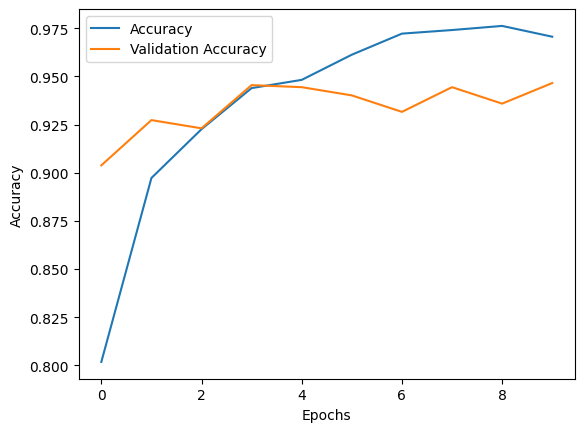

Predicting on ESP32-CAM images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: tomato-leaves-early-blight-cropped.jpg --> Predicted Disease: Leaf_Mold (Confidence: 88.22%)


In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os


drive.mount('/content/drive')


dataset_folder = "/content/drive/My Drive/tomato_disease_dataset"
base_folder = "/content/drive/My Drive/ESP32-CAM/20241126"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
classes = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Healthy']


train_dataset = image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


checkpoint_path = "/content/drive/My Drive/best_model.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max'
                                                )
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[checkpoint])


plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Batch Prediction Function
def batch_predict(base_folder, model):
    images = []
    image_paths = []

    for img_file in os.listdir(base_folder):
        img_path = os.path.join(base_folder, img_file)
        if os.path.isfile(img_path) and img_file.endswith(('.jpg', '.png')):
            img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = tf.keras.utils.img_to_array(img) / 255.0
            images.append(img_array)
            image_paths.append(img_file)

    images = tf.convert_to_tensor(images)
    predictions = model.predict(images)

    for idx, prediction in enumerate(predictions):
        class_idx = tf.argmax(prediction).numpy()
        confidence = prediction[class_idx] * 100
        print(f"Image: {image_paths[idx]} --> Predicted Disease: {classes[class_idx]} (Confidence: {confidence:.2f}%)")

# Predict on ESP32-CAM Images
print("Predicting on ESP32-CAM images...")
model = tf.keras.models.load_model(checkpoint_path)
batch_predict(base_folder, model)
